In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from multiprocessing import Pool
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
## Dataset

In [3]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [5]:
data.n_people.sum()

21003

In [6]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


In [7]:
submission.shape

(5000, 1)

In [8]:
## Loss Function

In [9]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [10]:
family_size_ls = list(family_size_dict.values())
choice_dict_num = [{vv:i for i, vv in enumerate(di.values())} for di in choice_dict.values()]

# Computer penalities in a list
penalties_dict = {
    n: [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ]
    for n in range(max(family_size_dict.values())+1)
} 

In [11]:
def cost_function(prediction):
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, c, c_dict, choice in zip(family_size_ls, prediction, list(choice_dict.values()), choice_dict_num):
        
        d = int(c)
        # Day
        #if c == 10:
        #    d = random.randint(1, 100)
        #else:
        #    d = c_dict['choice_{}'.format(c)]
        
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d not in choice:
            penalty += penalties_dict[n][-1]
        else:
            penalty += penalties_dict[n][choice[d]]

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    k = 0
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY):
            k = k + (v - MAX_OCCUPANCY)
        if (v < MIN_OCCUPANCY):
            k = k + (MIN_OCCUPANCY - v)
    #    if k > 0:
    #        penalty += 100000000 
    penalty += (2*penalty)*(k/21003)

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return (penalty, )

## Particle Swarm Optimization

In [12]:

import array
import logging
import random

import numpy

from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import multiprocessing
pool = multiprocessing.Pool()

In [22]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Geral
#toolbox.register("map", pool.map)

# Attribute generator
toolbox.register("attr_int",   random.randint, 1, 100)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 5000)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate",   cost_function)
toolbox.register("mate",       tools.cxUniform, indpb=0.1)
toolbox.register("mutate",     tools.mutUniformInt, low=1, up=100, indpb=0.05)
toolbox.register("select",     tools.selNSGA2)

/home/marlesson/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/marlesson/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [23]:
# random.seed(64)
MU, LAMBDA = 100, 100
ngen       = 5
mutpb      = 0.3 #0.3
cxpb       = 0.7 #0.7

pop   = toolbox.population(n=MU)
hof   = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)

In [24]:
#10 635 376
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                         cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                         stats=stats, halloffame=hof)

gen	nevals	avg                	std                	min                	max             
0  	100   	[32385248.90350594]	[76847362.49714954]	[10782782.18322937]	[5.68738631e+08]
1  	100   	[11613228.9275302] 	[653196.60527499]  	[10635376.0109945] 	[13034374.62410561]
2  	100   	[11096232.79632314]	[225818.30976968]  	[10635376.0109945] 	[11497151.67977227]
3  	100   	[10915718.40610626]	[118820.83038711]  	[10635376.0109945] 	[11136455.13118567]
4  	100   	[10841809.23443327]	[73407.71602352]   	[10635376.0109945] 	[10958142.44581975]
5  	100   	[10786446.15842716]	[55850.96250344]   	[10635376.0109945] 	[10871581.87397529]


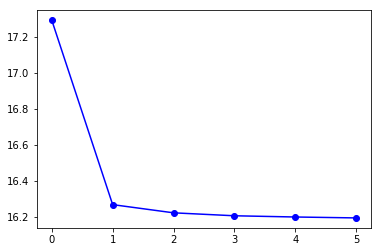

In [74]:
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0], np.log(front[:,1]), "-bo", c="b")
plt.axis("tight")
plt.show()

In [81]:
pop[0]

[18,
 75,
 56,
 20,
 87,
 93,
 65,
 59,
 26,
 83,
 94,
 62,
 7,
 52,
 81,
 38,
 71,
 45,
 19,
 83,
 57,
 39,
 92,
 51,
 37,
 18,
 74,
 18,
 4,
 22,
 61,
 51,
 69,
 2,
 93,
 18,
 73,
 87,
 48,
 71,
 41,
 89,
 95,
 38,
 55,
 70,
 78,
 65,
 41,
 27,
 59,
 21,
 4,
 45,
 39,
 98,
 58,
 58,
 77,
 88,
 13,
 32,
 100,
 67,
 40,
 91,
 36,
 87,
 76,
 65,
 94,
 46,
 3,
 54,
 88,
 50,
 96,
 78,
 12,
 47,
 49,
 4,
 80,
 71,
 18,
 93,
 17,
 65,
 3,
 24,
 13,
 44,
 71,
 90,
 8,
 22,
 48,
 36,
 9,
 9,
 36,
 39,
 35,
 1,
 91,
 59,
 84,
 61,
 35,
 62,
 1,
 39,
 5,
 12,
 20,
 75,
 67,
 25,
 63,
 37,
 58,
 12,
 57,
 13,
 66,
 24,
 27,
 74,
 26,
 51,
 6,
 31,
 90,
 67,
 25,
 67,
 94,
 41,
 82,
 45,
 76,
 65,
 45,
 65,
 49,
 49,
 79,
 64,
 38,
 25,
 88,
 76,
 46,
 57,
 87,
 73,
 59,
 59,
 39,
 86,
 38,
 27,
 74,
 32,
 36,
 95,
 56,
 76,
 80,
 33,
 91,
 27,
 9,
 13,
 53,
 75,
 39,
 24,
 38,
 94,
 51,
 19,
 74,
 10,
 47,
 39,
 90,
 35,
 82,
 5,
 69,
 52,
 77,
 82,
 97,
 34,
 67,
 75,
 90,
 47,
 68,
 99,
 61,


In [79]:
tools.evaluate

best_ind = tools.selBest(pop, 1)[0]
best_ind

AttributeError: module 'deap.tools' has no attribute 'evaluate'

In [31]:

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
FAMINY_SIZE   = 5000
DAYS          = list(range(N_DAYS,0,-1))

In [32]:
# We'll use this to count the number of people scheduled each day
daily_occupancy = {k:0 for k in DAYS}

# Looping over each family; d is the day, n is size of that family, 
# and choice is their top choices
for n, d, choice in zip(family_size_ls, best_ind, choice_dict_num):
    # add the family member count to the daily occupancy
    daily_occupancy[d] += n

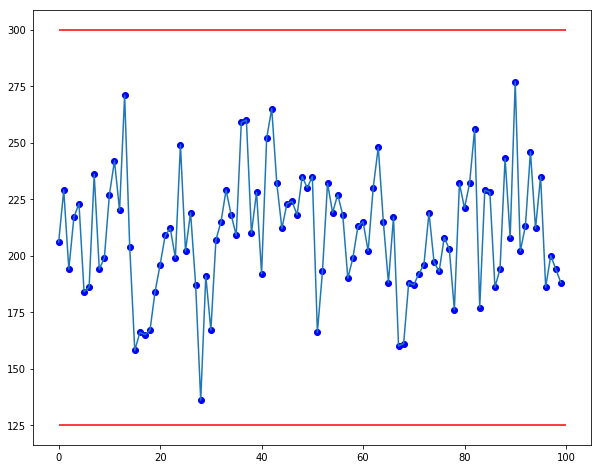

In [70]:
plt.figure(figsize=(10,8))
plt.hlines(MAX_OCCUPANCY, 0, 100, color='r')
plt.plot(list(daily_occupancy.values()), 'bo')
plt.plot(list(daily_occupancy.values()))
plt.hlines(MIN_OCCUPANCY, 0, 100, color='r')

In [49]:
def is_constraint(prediction):
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in DAYS}
    
    # Looping over each family; d is the day, n is size of that family, 
    # and choice is their top choices
    for n, d, choice in zip(family_size_ls, prediction, choice_dict_num):
        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for v in daily_occupancy.values():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            return True
    return False

is_constraint(best_ind)

False

In [51]:
#print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
best_solution =  best_ind

days = []
for n, c, c_dict in zip(family_size_ls, best_solution, list(choice_dict.values())):
    days.append(c)
days

submission['assigned_day']=days
submission.to_csv('submission2.csv')

In [ ]:
best_solution

In [ ]:
aaa

## Genetic Algorithm

Basic Description
Genetic algorithms are inspired by Darwin's theory about evolution. Solution to a problem solved by genetic algorithms is evolved.

Algorithm is started with a set of solutions (represented by chromosomes) called population. Solutions from one population are taken and used to form a new population. This is motivated by a hope, that the new population will be better than the old one. Solutions which are selected to form new solutions (offspring) are selected according to their fitness - the more suitable they are the more chances they have to reproduce.

Outline of the Basic Genetic Algorithm
* **[Start]** Generate random population of n chromosomes (suitable solutions for the problem)
* **[Fitness]** Evaluate the fitness f(x) of each chromosome x in the population
    * **[New population]** Create a new population by repeating following steps until the new population is complete
    * **[Selection]** Select two parent chromosomes from a population according to their fitness (the better fitness, the bigger chance to be selected)
    * **[Crossover]** With a crossover probability cross over the parents to form a new offspring (children). If no crossover was performed, offspring is an exact copy of parents.
    * **[Mutation]** With a mutation probability mutate new offspring at each locus (position in chromosome).
    * [Accepting] Place new offspring in a new population
* **[Replace]** Use new generated population for a further run of algorithm
* **[Test]** If the end condition is satisfied, stop, and return the best solution in current population
* **[Loop]** Go to step 2

http://www.obitko.com/tutorials/genetic-algorithms/ga-basic-description.php


In [ ]:
from tqdm import tqdm
from itertools import starmap



"""Genetic Algorithmn Implementation
see:
http://www.obitko.com/tutorials/genetic-algorithms/ga-basic-description.php
"""
class GeneticAlgorithm(object):
    def __init__(self, genetics):
        self.genetics       = genetics
        self.best_solution  = None
        self.avg_fitness    = []
        pass

    def fitness(self, ch):
        return (self.genetics.fitness(ch),  ch)
    
    def run(self, processes=4):
        population = self.genetics.initial()
        pool       = Pool(processes=processes)
        
        while True:
            #fits_pops = [self.fitness(ch) for ch in population]
            fits_pops = pool.map(self.fitness, population)
            #fits_pops = list(tqdm(starmap(self.fitness, population), total=len(population)))
            
            fits_pops = list(sorted(fits_pops))
            
            # Log
            self.avg_fitness.append(np.median([f for f, ch in fits_pops]))
            self.best_solution = fits_pops[0][1]
            
            if self.genetics.check_stop(fits_pops): 
                break
            
            population = self.next(fits_pops)
            pass
        return population

    def next(self, fits):
        parents_generator = self.genetics.parents(fits)
        size  = len(fits)
        nexts = [self.best_solution.copy()]
        while len(nexts) < size:
            parents  = next(parents_generator)
            cross    = random.random() < self.genetics.probability_crossover()
            children = self.genetics.crossover(parents) if cross else parents

            for ch in children:
                mutate = random.random() < self.genetics.probability_mutation()
                nexts.append(self.genetics.mutation(ch) if mutate else ch)
                pass
            pass
        return nexts[0:size]
    pass

#### Genetic Algorithms: ...


In [ ]:
class SantasWorkshop():
    def __init__(self, df, data, generation=10, size=5,
                 prob_crossover=0.9, prob_mutation=0.2,
                mutation_size = 0.1):
        self.df        = df
        self.data      = data
        self.counter   = 0
        
        self.generation = generation
        self.size  = size        
        self.prob_crossover = prob_crossover
        self.prob_mutation  = prob_mutation
        self.mutation_size  = mutation_size

    # GeneticFunctions interface impls
    def probability_crossover(self):
        return self.prob_crossover

    def probability_mutation(self):
        return self.prob_mutation

    # Initial population based in s0
    def initial(self):
        population = [self.random_chromo() for j in range(self.size)]
        return population

    def fitness(self, chromo):
        score = cost_function(chromo)
        return score

    def check_stop(self, fits_populations):
        self.counter += 1
        
        if self.counter % 2 == 0:

            fits  = [f for f, ch in fits_populations]
            best  = min(fits)
            worst = max(fits)
            ave   = sum(fits) / len(fits)
            print(
                "[G %3d] score=(%2f, %2f, %2f, %2f): %r" %
                (self.counter, best, ave, worst, len(fits), []))
            pass

        return self.counter >= self.generation

    def parents(self, fits_populations):
        while True:
            father = self.tournament(fits_populations)
            mother = self.tournament(fits_populations)
            yield (father, mother)
            pass
        pass

    def crossover(self, parents):
        ind1, ind2 = parents
        
        size = min(len(ind1), len(ind2))
        a, b = random.sample(range(size), 2)
        if a > b:
            a, b = b, a

        holes1, holes2 = [True]*size, [True]*size
        for i in range(size):
            if i < a or i > b:
                holes1[ind2[i]-1] = False
                holes2[ind1[i]-1] = False

        # We must keep the original values somewhere before scrambling everything
        temp1, temp2 = ind1, ind2
        k1 , k2 = b + 1, b + 1
        for i in range(size):
            if not holes1[temp1[(i + b + 1) % size]-1]:
                ind1[k1 % size] = temp1[(i + b + 1) % size]
                k1 += 1

            if not holes2[temp2[(i + b + 1) % size]-1]:
                ind2[k2 % size] = temp2[(i + b + 1) % size]
                k2 += 1

        # Swap the content between a and b (included)
        for i in range(a, b + 1):
            ind1[i], ind2[i] = ind2[i], ind1[i]

        return ind1, ind2

    def mutation(self, chromosome):
        mutated = chromosome
        
        for k in range(int(len(chromosome)*self.mutation_size)):
            i = random.randint(0, len(chromosome)-1)
            mutated[i] = random.choice(self.data.loc[i].values[:-1])

        return mutated

    def tournament(self, fits_populations):
        alicef, alice = self.select_random(fits_populations)
        bobf, bob = self.select_random(fits_populations)
        return alice if alicef < bobf else bob

    def select_random(self, fits_populations):
        return fits_populations[random.randint(0, len(fits_populations)-1)]

    def random_chromo(self):
        chromo = [random.choice(data.loc[i].values[:-1]) for i in range(len(df))]
        
        #chromo = list(df.assigned_day.sample(frac=1).values)
        return chromo
    pass

## Compute GA

In [ ]:
df = submission

In [ ]:
#%%time

df = submission#['assigned_day']

generation      = 200
population_size = 1000
prob_crossover  = 0.9
prob_mutation   = 0.2

ga = GeneticAlgorithm(
    SantasWorkshop(df, data, generation=generation, size=population_size, 
                   prob_crossover=prob_crossover, prob_mutation=prob_mutation)
)

best_solution = ga.run()

In [ ]:
is_constraint(best_solution[0])

In [ ]:
#plt.plot(ga.avg_fitness)
t = 50
sns.lineplot(y=ga.avg_fitness[t:], x=range(len(ga.avg_fitness[t:])))

In [ ]:
len(ga.avg_fitness)

In [ ]:
# g = SantasWorkshop(df, data, generation=generation, size=population_size, 
#                    prob_crossover=prob_crossover, prob_mutation=prob_mutation)

# chromo = g.random_chromo()
# cost_function(chromo)

In [ ]:
%%time

df = submission#['assigned_day']

generation      = 50
population_size = 100
prob_crossover  = 0.9
prob_mutation   = 0.5

ga = GeneticAlgorithm(
    SantasWorkshop(df, generation=generation, size=population_size, 
                   prob_crossover=prob_crossover, prob_mutation=prob_mutation)
)

best_solution = ga.run()